In [1]:
import json
from tqdm import tqdm
from valerie.data import load_claims, claims_from_phase2
from valerie.modeling import ClaimantModel
from valerie.scoring import compute_detailed_score_phase2, validate_predictions_phase2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Report
---

In [2]:
with open("data/phase2/trial-data/metadata.json") as fi:
    labels = {str(claim["id"]): claim for claim in json.load(fi)}
with open("data/phase2/trial-data/predictions.json") as fi:
    predictions = json.load(fi)

In [3]:
if not validate_predictions_phase2(predictions)[1]:
        raise ValueError("validate_predictions_phase2 failed")
report, output, official_output = compute_detailed_score_phase2(labels, predictions)

In [4]:
print(json.dumps(output, indent=2))

{
  "score": 0.7463429816370993,
  "perfect_score": 1.0046685340802988,
  "scores:": {
    "score_0": 0.31746031746031744,
    "score_1": 0.5882352941176471,
    "score_2": 1.3333333333333333
  },
  "perfect_scores": {
    "score_0": 0.8571428571428571,
    "score_1": 0.8235294117647058,
    "score_2": 1.3333333333333333
  }
}


In [5]:
print(report)

precision    recall  f1-score   support

           0       0.51      0.78      0.62        41
           1       0.56      0.50      0.53        38
           2       1.00      0.14      0.25        21

    accuracy                           0.54       100
   macro avg       0.69      0.47      0.46       100
weighted avg       0.63      0.54      0.51       100



In [6]:
# print(json.dumps(official_output, indent=2))

# Claimant Experiments
---

In [15]:
train_claims = load_claims("data/phase1/all-data/claims.json", as_list=True)
train_claims += load_claims("data/phase2/train-data/claims.json", as_list=True)
# train_claims += load_claims("data/phase2/all-data/claims.json", as_list=True)

test_claims = load_claims("data/phase2/test-data/claims.json", as_list=True)
with open("data/phase2/trial-data/predictions.json") as fi:
    trial_predictions = json.load(fi)
trial_claims = load_claims("data/phase2/trial-data/claims.json", as_list=True)

loading claims: 100%|██████████| 100/100 [00:00<00:00, 8221.06it/s]


In [31]:
model = ClaimantModel()
model.train(train_claims, min_threshold=10)

In [ ]:
results = {}

for thres in [round(0.33 + x*0.01, 2) for x in range(int((0.9-0.33)/0.01))]:
    claimant_claims = []
    claimant_predictions = []
    claimant_labels = []
    normal_claims = []
    normal_predictions = []
    normal_labels = []

    for claim in trial_claims:
        if model.predict(claim) is not None and max(model.predict(claim)) > thres:
            claimant_claims.append(claim)
            claimant_predictions.append(np.argmax(model.predict(claim)))
            claimant_labels.append(claim.label)
        else:
            normal_claims.append(claim)
            normal_predictions.append(trial_predictions[str(claim.id)]["label"])
            normal_labels.append(claim.label)
    
    all_predictions = claimant_predictions + normal_predictions
    all_labels = claimant_labels + normal_labels
    assert len(all_predictions) == len(trial_claims), "%d, %d" % (len(all_predictions), len(trial_claims))

    results[thres] = {
        "all": {
            "report_dict": classification_report(all_labels, all_predictions, output_dict=True),
            "report_str": classification_report(all_labels, all_predictions),
            "claims": trial_claims,
            "predictions": all_predictions,
            "labels": all_labels,
        },
        "claimant": {
            "report_dict": classification_report(claimant_labels, claimant_predictions, output_dict=True),
            "report_str": classification_report(claimant_labels, claimant_predictions),
            "claims": claimant_claims,
            "predictions": claimant_predictions,
            "labels": claimant_labels,
        },
        "normal": {
            "report_dict": classification_report(normal_labels, normal_predictions, output_dict=True),
            "report_str": classification_report(normal_labels, normal_predictions),
            "claims": normal_claims,
            "predictions": normal_predictions,
            "labels": normal_labels,
        },
    }

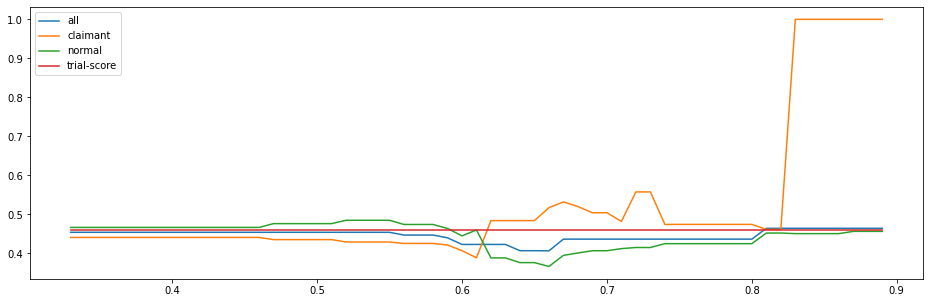

In [33]:
plt.figure(num=None, figsize=(16, 5))
plt.plot(list(results), [x["all"]["report_dict"]["macro avg"]["f1-score"] for x in results.values()])
plt.plot(list(results), [x["claimant"]["report_dict"]["macro avg"]["f1-score"] for x in results.values()])
plt.plot(list(results), [x["normal"]["report_dict"]["macro avg"]["f1-score"] for x in results.values()])
plt.plot(list(results), [0.46]*len(results))
plt.legend(["all", "claimant", "normal", "trial-score"], loc="upper left")